In [1]:
#import libery
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout

In [2]:
#load data
data = pd.read_csv('trainData.csv')

In [3]:
#row 1258 and column 6
data.shape

(1258, 6)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [5]:
data.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [6]:
#convert numerical data
data["Close"]=pd.to_numeric(data.Close,errors='coerce')

In [7]:
#drop null value
data = data.dropna() 

In [8]:
#selecting only the closing prices for training
trainData = data.iloc[:,4:5].values
trainData

array([[663.59],
       [666.45],
       [657.21],
       ...,
       [785.05],
       [782.79],
       [771.82]])

In [9]:
#scaling the values in the range of 0-1 for best preformances
sc = MinMaxScaler(feature_range=(0,1))
trainData = sc.fit_transform(trainData)
trainData.shape

(1149, 1)

# preparing the data for LSTM

#since its a time series problem we took 60 as timestep for our learning : given 60 closing values as an input data the 61st value is our output

In [10]:
X_train = []
y_train = []

for i in range (60,1149): #60 : timestep // 1149 : length of the data
    X_train.append(trainData[i-60:i,0]) 
    y_train.append(trainData[i,0])

X_train,y_train = np.array(X_train),np.array(y_train)

In [11]:
X_train,y_train

(array([[0.40001392, 0.40665027, 0.38520976, ..., 0.36279469, 0.35745777,
         0.37766846],
        [0.40665027, 0.38520976, 0.36439577, ..., 0.35745777, 0.37766846,
         0.36065992],
        [0.38520976, 0.36439577, 0.30063115, ..., 0.37766846, 0.36065992,
         0.34406906],
        ...,
        [0.65286802, 0.66184797, 0.66194078, ..., 0.69625951, 0.69312697,
         0.69693243],
        [0.66184797, 0.66194078, 0.66284574, ..., 0.69312697, 0.69693243,
         0.68184982],
        [0.66194078, 0.66284574, 0.65871543, ..., 0.69693243, 0.68184982,
         0.67660572]]),
 array([0.36065992, 0.34406906, 0.35722573, ..., 0.68184982, 0.67660572,
        0.65115092]))

ps : LSTM take a 3D tensor (seq_len,timestep,batch_size)

In [12]:
#adding the batch_size axis
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_train.shape

(1089, 60, 1)

# building the model

In [13]:
model = Sequential()

model.add(LSTM(units=100, return_sequences = True, input_shape =(X_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units =1))
model.compile(optimizer='adam',loss="mean_squared_error")

In [14]:
hist = model.fit(X_train, y_train, epochs = 20, batch_size = 32, verbose=1)

Epoch 1/20
35/35 [==============================] - 11s 161ms/step - loss: 0.0586
Epoch 2/20
35/35 [==============================] - 9s 252ms/step - loss: 0.0158
Epoch 3/20
35/35 [==============================] - 10s 292ms/step - loss: 0.0135
Epoch 4/20
35/35 [==============================] - 10s 293ms/step - loss: 0.0095
Epoch 5/20
35/35 [==============================] - 10s 275ms/step - loss: 0.0070
Epoch 6/20
35/35 [==============================] - 9s 261ms/step - loss: 0.0070
Epoch 7/20
35/35 [==============================] - 10s 280ms/step - loss: 0.0079
Epoch 8/20
35/35 [==============================] - 9s 259ms/step - loss: 0.0061
Epoch 9/20
35/35 [==============================] - 10s 285ms/step - loss: 0.0133
Epoch 10/20
35/35 [==============================] - 10s 280ms/step - loss: 0.0084
Epoch 11/20
35/35 [==============================] - 9s 259ms/step - loss: 0.0054
Epoch 12/20
35/35 [==============================] - 9s 242ms/step - loss: 0.0053
Epoch 13/20
35/35 

ploting the training loss

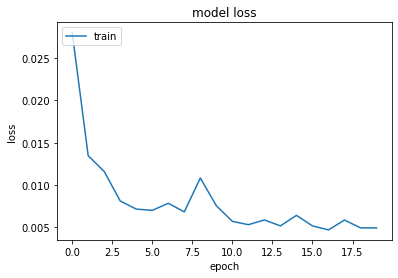

In [15]:
plt.plot(hist.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()


Predicting for test data

As we have 60 input in our layer, we will concatenate our train and test and will take last 60 values of our training set with test set


In [16]:
testData = pd.read_csv('GOOG.csv') #importing the test data
testData["Close"]=pd.to_numeric(testData.Close,errors='coerce') #turning the close column to numerical type
testData = testData.dropna() #droping the NA values
testData = testData.iloc[:,4:5] #selecting the closing prices for testing
y_test = testData.iloc[60:,0:].values #selecting the labels 
#input array for the model
inputClosing = testData.iloc[:,0:].values 
inputClosing_scaled = sc.transform(inputClosing)
inputClosing_scaled.shape
X_test = []
length = len(testData)
timestep = 60
for i in range(timestep,length): #doing the same preivous preprocessing 
    X_test.append(inputClosing_scaled[i-timestep:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
X_test.shape

(192, 60, 1)

In [17]:
y_pred = model.predict(X_test) #predicting the new values

In [18]:
y_pred

array([[1.1924342],
       [1.1938256],
       [1.2027601],
       [1.2170191],
       [1.2294517],
       [1.2313414],
       [1.2222177],
       [1.2078481],
       [1.1973994],
       [1.1933078],
       [1.1866971],
       [1.1766056],
       [1.1671379],
       [1.15811  ],
       [1.1548463],
       [1.15722  ],
       [1.1711891],
       [1.1947157],
       [1.2229341],
       [1.2521317],
       [1.2668357],
       [1.2680659],
       [1.2541538],
       [1.231117 ],
       [1.2083439],
       [1.1934218],
       [1.1875981],
       [1.1851121],
       [1.1780844],
       [1.1681701],
       [1.1570696],
       [1.1444137],
       [1.1261579],
       [1.1035757],
       [1.0922966],
       [1.0972351],
       [1.1136721],
       [1.1343446],
       [1.1552892],
       [1.1676079],
       [1.1798671],
       [1.1940354],
       [1.2102274],
       [1.2257208],
       [1.2371615],
       [1.2407641],
       [1.2347096],
       [1.2281808],
       [1.225984 ],
       [1.2302628],


In [19]:
predicted_price = sc.inverse_transform(y_pred) #inversing the scaling transformation for ploting

In [20]:
predicted_price

array([[1005.09143],
       [1005.69104],
       [1009.54144],
       [1015.6866 ],
       [1021.0445 ],
       [1021.8589 ],
       [1017.9269 ],
       [1011.73425],
       [1007.23126],
       [1005.4679 ],
       [1002.61896],
       [ 998.2699 ],
       [ 994.18976],
       [ 990.2991 ],
       [ 988.8925 ],
       [ 989.9155 ],
       [ 995.93567],
       [1006.0747 ],
       [1018.23566],
       [1030.8187 ],
       [1037.1555 ],
       [1037.6857 ],
       [1031.6901 ],
       [1021.7622 ],
       [1011.9478 ],
       [1005.5171 ],
       [1003.00726],
       [1001.9359 ],
       [ 998.9073 ],
       [ 994.6345 ],
       [ 989.85065],
       [ 984.39655],
       [ 976.529  ],
       [ 966.797  ],
       [ 961.93616],
       [ 964.0644 ],
       [ 971.14813],
       [ 980.0571 ],
       [ 989.08344],
       [ 994.3923 ],
       [ 999.67554],
       [1005.7815 ],
       [1012.7596 ],
       [1019.4366 ],
       [1024.3671 ],
       [1025.9197 ],
       [1023.3104 ],
       [1020.

ploting the results

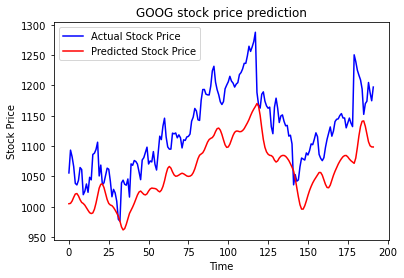

In [21]:
plt.plot(y_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price, color = 'red', label = 'Predicted Stock Price')
plt.title('GOOG stock price prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

